In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import shutil
import glob
import os
import numpy as np
import cv2

np.random.seed(0)

Preparing the datasest

In [7]:
len(os.listdir('./dataset/with_mask')), len(os.listdir('./dataset/without_mask'))

(690, 686)

In [30]:
os.makedirs('dataset/train/with_mask')
os.makedirs('dataset/valid/with_mask')
os.makedirs('dataset/test/with_mask')
os.makedirs('dataset/temp/with_mask')

os.makedirs('dataset/train/without_mask')
os.makedirs('dataset/valid/without_mask')
os.makedirs('dataset/test/without_mask')
os.makedirs('dataset/temp/without_mask')

In [33]:
images = os.listdir('dataset/without_mask')
np.random.shuffle(images)

for img in images[:int(len(images))]:
    shutil.move(f'dataset/without_mask/{img}', f'dataset/valid/without_mask/{img}')

In [38]:
sizes = set()
for img in os.listdir('./dataset/train/with_mask'):
    I = cv2.imread(f'./dataset/train/with_mask/{img}')
    sizes.add(I.shape)
    
min(sizes), max(sizes)

((152, 270, 3), (960, 956, 3))

In [6]:
len(os.listdir('./dataset/train/with_mask')), len(os.listdir('./dataset/train/without_mask'))

(115, 324)

Applying data augmentation technique in with_mask category

In [15]:
train_with_mask_img = os.listdir('./dataset/train/with_mask')
for i in range(len(train_with_mask_img)):
    name, ext = os.path.splitext(train_with_mask_img[i])
    image = cv2.imread(os.path.join('./dataset', 'train', 'with_mask', train_with_mask_img[i]))
    image = cv2.flip(image, 1)
    cv2.imwrite(os.path.join('./dataset', 'train', 'with_mask', f'{name}_flipped_h{ext}'), image)

Creating train, valid, and test data generators

In [2]:
train_path = './dataset/train'
valid_path = './dataset/valid'
test_path = './dataset/test'

train_batches = ImageDataGenerator(rescale=1/255.0).flow_from_directory(directory=train_path,
                    target_size=(128, 128), color_mode='grayscale', batch_size=8,
                    classes=['with_mask', 'without_mask'], shuffle=True)

valid_batches = ImageDataGenerator(rescale=1/255.0).flow_from_directory(directory=valid_path, 
                    target_size=(128, 128), color_mode='grayscale', batch_size=8, 
                    classes=['with_mask', 'without_mask'], shuffle=True)

test_batches = ImageDataGenerator(rescale=1/255.0).flow_from_directory(directory=test_path,
                    target_size=(128, 128), color_mode='grayscale', batch_size=8, 
                    classes=['with_mask', 'without_mask'], shuffle=False)

Found 554 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


Model

In [21]:
model = Sequential([
    Conv2D(128, (3,3), activation='relu', input_shape=(128, 128, 1)),
    Dropout(0.5),
    Conv2D(64, (3,3), activation='relu'),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [22]:
def callbacks(path):
    model_checkpoint = ModelCheckpoint(filepath=path,
                                       monitor='val_loss', 
                                       verbose=False,
                                       save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=5,
                                   min_delta=0.1)
    return model_checkpoint, early_stopping

Training the model

In [23]:
history = model.fit(train_batches, epochs=50, validation_data=valid_batches,
          callbacks=[callbacks('./trained_model/checkpoints')], verbose=1)

Epoch 1/50
70/70 [==============================] - 241s 3s/step - loss: 0.7198 - acc: 0.5632 - val_loss: 0.6680 - val_acc: 0.6750
Epoch 2/50
70/70 [==============================] - 251s 4s/step - loss: 0.6513 - acc: 0.6895 - val_loss: 0.4730 - val_acc: 0.6875
Epoch 3/50
70/70 [==============================] - 253s 4s/step - loss: 0.4448 - acc: 0.8357 - val_loss: 0.4244 - val_acc: 0.7375
Epoch 4/50
70/70 [==============================] - 257s 4s/step - loss: 0.3129 - acc: 0.8917 - val_loss: 0.3871 - val_acc: 0.8625
Epoch 5/50
70/70 [==============================] - 276s 4s/step - loss: 0.2361 - acc: 0.9224 - val_loss: 0.5181 - val_acc: 0.8000
Epoch 6/50
70/70 [==============================] - 255s 4s/step - loss: 0.1081 - acc: 0.9621 - val_loss: 0.4987 - val_acc: 0.8500
Epoch 7/50
70/70 [==============================] - 254s 4s/step - loss: 0.0520 - acc: 0.9801 - val_loss: 0.6789 - val_acc: 0.7875


Ploting the training and valid loss and accuracy

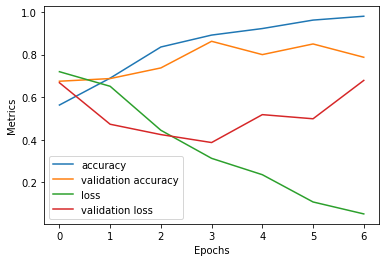

In [24]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

Evaluating the model on test dataset

In [25]:
model.evaluate(test_batches)

10/10 [==============================] - 6s 611ms/step - loss: 0.6554 - acc: 0.7973


[0.6553789377212524, 0.7972972989082336]

Saving the learned model

In [ ]:
model.save('./trained_model/')